In [138]:
%matplotlib inline
import sys
sys.path.insert(0, '/astro/users/ctslater/.local/lib/python3.6/site-packages')

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import astropy.coordinates
import astropy.units as u

#plt.style.use(("paper_plots.mplstyle"))

matplotlib.rcParams['figure.dpi'] = 80

from astropy.coordinates import Galactocentric, Galactic, ICRS

import healpy as hp
import pickle

cmap = matplotlib.cm.coolwarm.set_under('w')


Expected proper motion for a shell with flat rotation
=======

In [270]:
ra, dec = hp.pix2ang(hp.order2nside(7), np.arange(hp.nside2npix(hp.order2nside(7))),
                                    lonlat=True, nest=True)

equatorial_coords = astropy.coordinates.SkyCoord(ra*u.deg, dec*u.deg, 10*u.kpc, frame='icrs')
coords = equatorial_coords #equatorial_coords.galactic

galactocentric_angle = np.arctan2(coords.galactocentric.y, coords.galactocentric.x)
circular_vel = 210*u.km/u.s
vertical_vel = 0.0*u.km/u.s

gc_coord = Galactocentric(x=coords.galactocentric.x, y=coords.galactocentric.y, z=coords.galactocentric.z,
                          v_x = circular_vel * np.sin(galactocentric_angle),
                          v_y = circular_vel * np.cos(galactocentric_angle),
                          v_z = vertical_vel)

galactic_coords_w_pm = gc_coord.transform_to(Galactic)

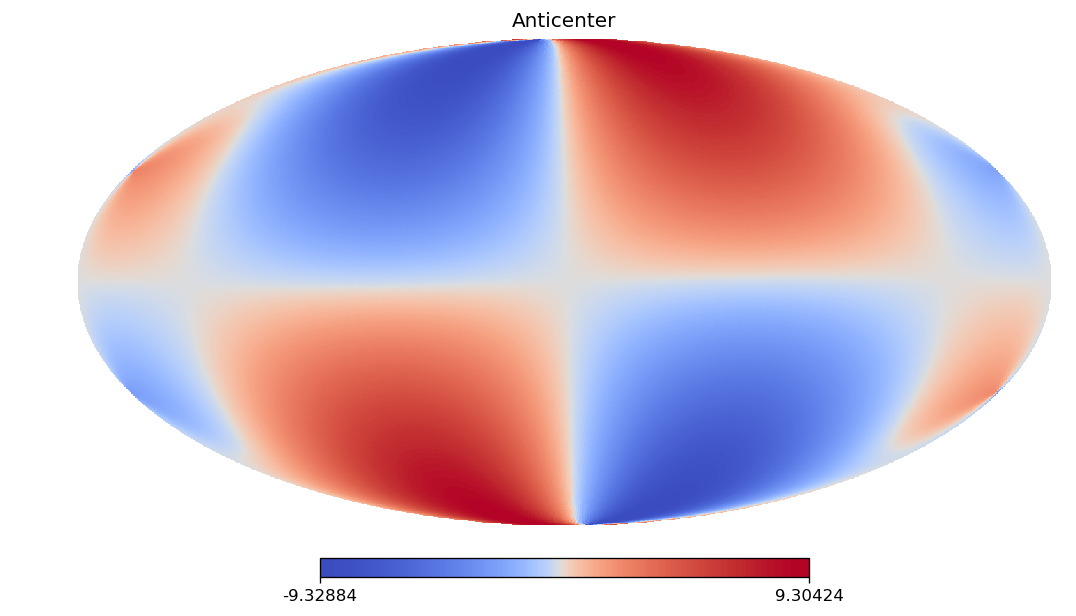

In [272]:
model_mean_mu_b = galactic_coords_w_pm.pm_b.to_value()
hp.mollview(model_mean_mu_b, title="Anticenter",
            #rot=(180, 0, 0),
            rot=(266.4 - 180, 28.94, -57),
            cmap='coolwarm', #min=-0.7, max=0.7,
            xsize=1400,  #min=0.1, max=2.0,
            nest=True, norm='hist')

Loading/wrangling the observed data from gaia_mu_b.ipynb
=========

In [37]:
with open("map_pos_b.pkl", "rb") as f:
    map_pos_b = pickle.load(f)
with open("map_negative_b.pkl", "rb") as f:
    map_negative_b = pickle.load(f)
with open("map_mean_b.pkl", "rb") as f:
    map_mean_b = pickle.load(f)    

In [121]:
#rot=(266.4 - 180, 28.94, -57 - 180)
rot=(266.4 - 180, 28.94, -57)
def create_rotation_index(rot):
    r = hp.Rotator(rot=rot, inv=False)
    lon, lat = hp.pix2ang(hp.order2nside(7), np.arange(hp.nside2npix(hp.order2nside(7))),
                          lonlat=False, nest=True)
    r_lon, r_lat = r(lon, lat)
    r_pix = hp.ang2pix(hp.order2nside(7), r_lon, r_lat, nest=True, lonlat=False)
    return r_pix

In [136]:
def make_scalebar(bins, value, fig, label=""):
    ax2 = fig.add_axes(matplotlib.axes.Axes(fig=fig, rect=[0.03, 0.15, 0.2, 0.08]))
    ax2.xaxis.set_visible(False)
    ax2.yaxis.set_visible(False)
    ax2.set_frame_on(False)
    ax2.plot([bins[0], bins[-1]], [0, 0], 'k-')

    ax2.text(0.5*(bins[0] + bins[-1]), -0.7, label, fontsize='x-large')
    for bin_n in [0, -1]:
        ax2.plot([bins[bin_n], bins[bin_n]], [-0.5, 1], 'k-')
        ax2.text(bins[bin_n], -1, "{:.1f}".format(bins[bin_n]), horizontalalignment="center", fontsize='large')
    ax2.plot([ value ]*2, [0, 1], 'b-', lw=3)        


Subtracting off the model from mean mu_b
========

Results are in `subtract_model_mu_b.pdf`

<Figure size 1020x648 with 0 Axes>

<Figure size 1020x648 with 0 Axes>

<Figure size 1020x648 with 0 Axes>

<Figure size 1020x648 with 0 Axes>

<Figure size 1020x648 with 0 Axes>

<Figure size 1020x648 with 0 Axes>

<Figure size 1020x648 with 0 Axes>

<Figure size 1020x648 with 0 Axes>

<Figure size 1020x648 with 0 Axes>

<Figure size 1020x648 with 0 Axes>

<Figure size 1020x648 with 0 Axes>

<Figure size 1020x648 with 0 Axes>

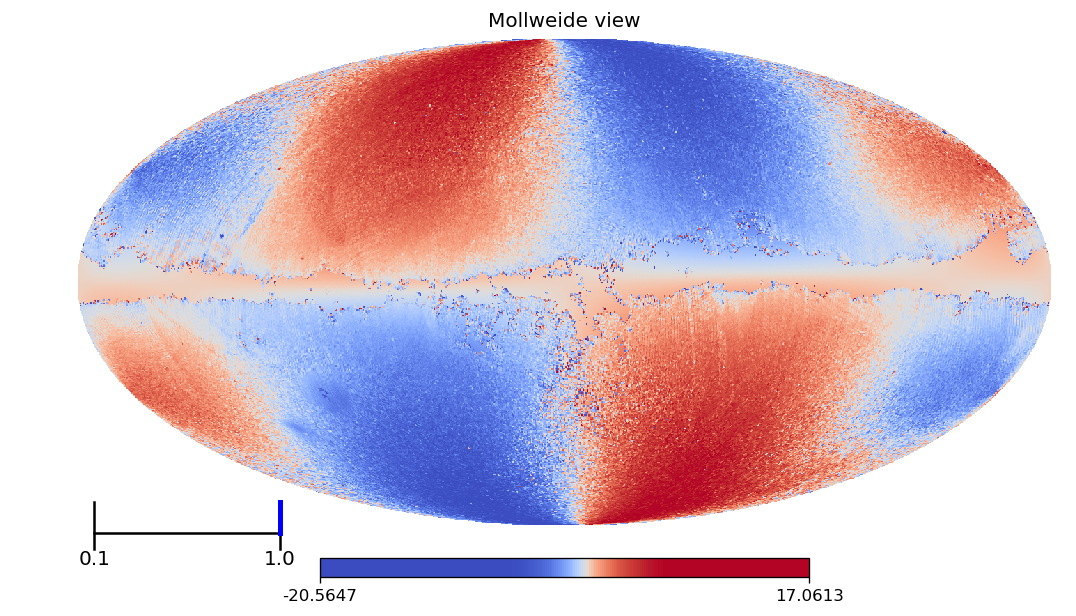

In [276]:
# map_mean_b is in equatorial healpix, model is in galactic healpix
from matplotlib.backends.backend_pdf import PdfPages


r_pix = create_rotation_index((266.4 - 180, 28.94, -57))
r_pix2 = create_rotation_index((180, 0, 0))

scale_iter = np.linspace(0.1, 1.0, 12)

model_scale = 1.0
adjusted_map = map_mean_b  - model_scale * model_mean_mu_b

hp.mollview(adjusted_map,
            cmap='coolwarm', #min=-0.7, max=0.7,
            rot=(266.4 - 180, 28.94, -57),
            xsize=1400,  #min=0.1, max=2.0,
            nest=True, norm='hist')

if True:
    with PdfPages('subtract_model_mu_b.pdf') as pdf:
        for model_scale in scale_iter:
            plt.clf()

            adjusted_map = map_mean_b  - model_scale * model_mean_mu_b

            hp.mollview(adjusted_map,
                        cmap='coolwarm', #min=-0.7, max=0.7,
                        rot=(266.4 - 180, 28.94, -57),
                        xsize=1400,  #min=0.1, max=2.0,
                        nest=True, norm='hist')
            make_scalebar(scale_iter, model_scale, plt.gcf())
            pdf.savefig();

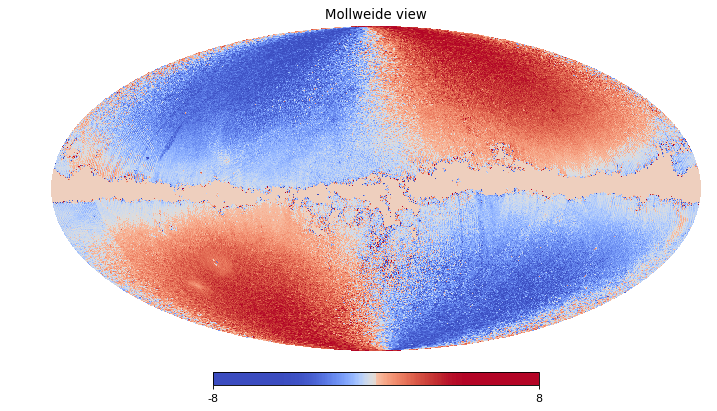

In [215]:

hp.mollview(map_mean_b,
            #map_mean_b * (np.abs(map_mean_b) < 5),
            rot=(266.4 - 180, 28.94, -57),
            cmap='coolwarm', min=-8, max=8,
            xsize=1400,  #min=0.1, max=2.0,
            nest=True, norm='hist')

Tuning the model to match the observations
=======

In [228]:
def model_pm_b(slice_longitudes, slice_latitudes, dist=10.0, circular_vel=210.0, radial_vel=0.0):
    coords = astropy.coordinates.SkyCoord(slice_longitudes*u.deg,
                                          slice_latitudes*u.deg, 
                                          dist*u.kpc, frame='galactic')

    galactocentric_angle = np.arctan2(coords.galactocentric.y, coords.galactocentric.x)
    vertical_vel = 0.0

    gc_coord = Galactocentric(x=coords.galactocentric.x, y=coords.galactocentric.y, z=coords.galactocentric.z,
                              v_x = (circular_vel * np.sin(galactocentric_angle) * u.km/u.s +
                                     radial_vel   * np.cos(galactocentric_angle) * u.km/u.s),
                              v_y = (circular_vel * np.cos(galactocentric_angle) * u.km/u.s +
                                     radial_vel   * np.sin(galactocentric_angle) * u.km/u.s),
                              v_z = vertical_vel * u.km/u.s)

    galactic_coords_w_pm = gc_coord.transform_to(Galactic)
    return coords, galactic_coords_w_pm.pm_b.to_value()

# y = 8, x=0, atan=pi/2, v_x_circ = 200, v_x_y = 0

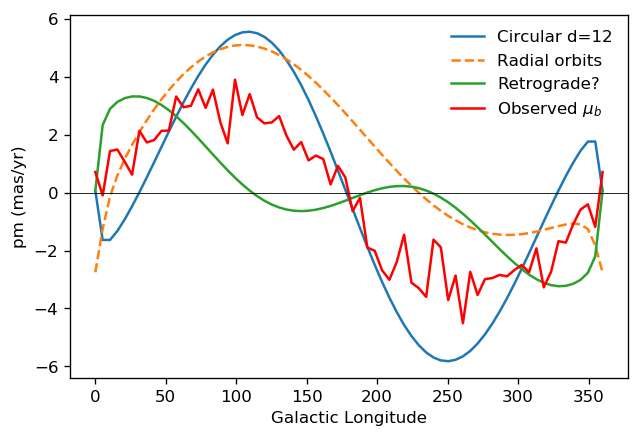

In [241]:
plt.figure(dpi=120)
slice_longitudes = np.linspace(0, 360, 70)
slice_latitudes = 50 + np.zeros(len(slice_longitudes))

for dist in [12]: #[6, 8, 10, 12]:
    coords, pro_model_result = model_pm_b(slice_longitudes, slice_latitudes, dist=dist, circular_vel=210.0)
    plt.plot(single_longitudes, pro_model_result, '-', label=r"Circular d={:.0f}".format(dist))

    
coords, model_result = model_pm_b(slice_longitudes, slice_latitudes, dist=dist, circular_vel=0.0, radial_vel=-210.0)
plt.plot(single_longitudes, model_result, '--', label=r"Radial orbits".format(dist))
    
for dist in [12]: #[6, 8, 10, 12]:
    coords, retro_model_result = model_pm_b(slice_longitudes, slice_latitudes, dist=dist, circular_vel=-210.0)
    plt.plot(single_longitudes, retro_model_result, '-', label=r"Retrograde?".format(dist))
    
#plt.plot(single_longitudes, 0.5*(retro_model_result + pro_model_result), '-', label=r"50/50".format(dist))
    
r_pix = hp.ang2pix(hp.order2nside(7),
                   coords.icrs.ra.to_value(),
                   coords.icrs.dec.to_value(),
                   nest=True, lonlat=True)
plt.plot(single_longitudes, map_mean_b[r_pix], 'r-', label=r"Observed $\mu_b$")
plt.xlabel("Galactic Longitude")
plt.ylabel("pm (mas/yr)")
plt.legend(loc=0, frameon=False)
plt.axhline(0, color='k', lw=0.5)

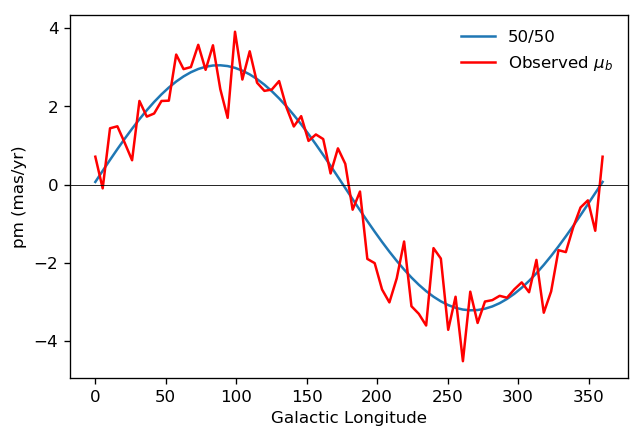

In [240]:
plt.figure(dpi=120)

plt.plot(single_longitudes, 0.5*(retro_model_result + pro_model_result), '-', label=r"50/50".format(dist))    

plt.plot(single_longitudes, map_mean_b[r_pix], 'r-', label=r"Observed $\mu_b$")
plt.xlabel("Galactic Longitude")
plt.ylabel("pm (mas/yr)")
plt.legend(loc=0, frameon=False)
plt.axhline(0, color='k', lw=0.5)

<Figure size 720x480 with 0 Axes>

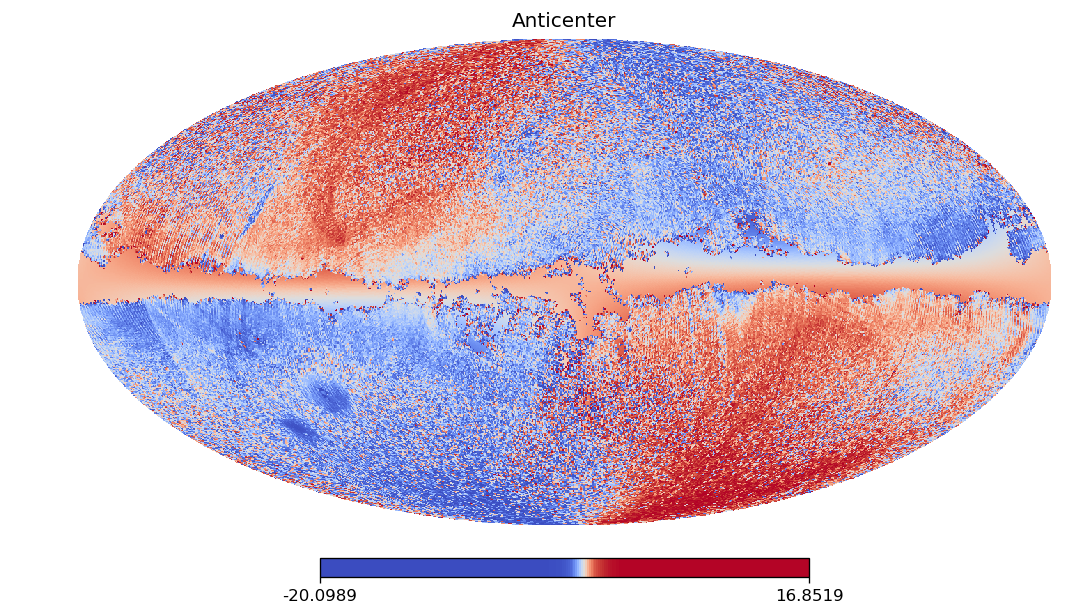

In [281]:
matplotlib.rcParams['figure.dpi'] = 120

ra, dec = hp.pix2ang(hp.order2nside(7), np.arange(hp.nside2npix(hp.order2nside(7))),
                                    lonlat=True, nest=True)

equ_coords = astropy.coordinates.SkyCoord(ra*u.deg, dec*u.deg, 10*u.kpc, frame='icrs')
gal_l = equ_coords.galactic.l.to_value()
gal_b = equ_coords.galactic.b.to_value()

coords, prograde_model = model_pm_b(gal_l, gal_b, dist=12.0, circular_vel=210.0, radial_vel=0.0)
coords, retrograde_model = model_pm_b(gal_l, gal_b, dist=12.0, circular_vel=-210.0, radial_vel=0.0)
model_mean_mu_b = 0.5*(prograde_model + retrograde_model)

model_scale = 0.9

r_pix = create_rotation_index((266.4 - 180, 28.94, -57))
r_pix2 = create_rotation_index((180, 0, 0))

scale_iter = np.linspace(0.8, 1.2, 12)
with PdfPages('subtract_model_mu_b2.pdf') as pdf:
    for model_scale in scale_iter:
        plt.clf()
        
        #adjusted_map = np.zeros(len(map_mean_b))
        #adjusted_map[r_pix] = map_mean_b 
        #adjusted_map[r_pix2] += -model_scale * model_mean_mu_b
        adjusted_map = map_mean_b - model_scale * model_mean_mu_b

        hp.mollview(adjusted_map, title="Anticenter",
                rot=(266.4 - 180, 28.94, -57),
                cmap='coolwarm', #min=-0.7, max=0.7,
                xsize=1400,  #min=0.1, max=2.0,
                nest=True, norm='hist', fig=0)
        pdf.savefig();        

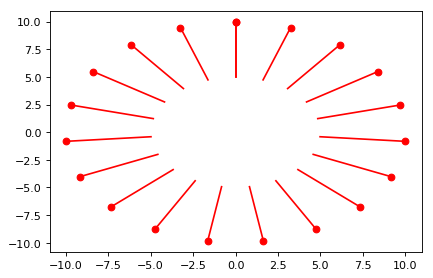

In [224]:
r = 10
angles = np.linspace(0, 2*np.pi, 20)
x = r*np.sin(angles)
y = r*np.cos(angles)

galactocentric_angle = np.arctan2(y, x)

radial_vel = -5
circular_vel = 0
v_x = (circular_vel * np.sin(galactocentric_angle) +
     radial_vel   * np.cos(galactocentric_angle) )
v_y = (circular_vel * np.cos(galactocentric_angle)  +
     radial_vel   * np.sin(galactocentric_angle))

for _x, _y, _v_x, _v_y in zip(x, y, v_x, v_y):
    plt.plot([_x], [_y], 'ro')
    plt.plot([_x, _x + _v_x], [_y, _y + _v_y], 'r-')